# Author: Tim Harmling and Alexej Kravtschenko
- **Note:** This notebook was written by the combined effort of Tim Harmling and Alexej Kravtschenko 
- **Description:** Automatic Workflow to Transfer Learn the Handwriting Model

In [1]:
#import handwriting.load_data as load_data
import load_transfer_data
import load_data
import models as models # Use: build_model9v3(img_width, img_height, char) 
#Imports
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pathlib
import pickle
import time
import os
import re


Maximum length:  29
Vocab size:  66


## Config

In [2]:
from config import *

## Load Data

In [3]:
x_train_img_paths, y_train_labels = load_transfer_data.get_train_data()
x_val_img_paths, y_val_labels = load_transfer_data.get_validation_data()

In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
#print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['dataset/transfer_dataset\\train\\10_10.jpg', 'dataset/transfer_dataset\\train\\10_11.jpg'] ['Fabian', '12A']
Validation path: ['dataset/transfer_dataset\\val\\0_0.jpg', 'dataset/transfer_dataset\\val\\0_1.jpg'] ['Lüdtke', 'Markus']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer

train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels, (IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)
aug_train_ds = tokenizer.prepare_augmented_dataset(x_train_img_paths, y_train_labels, BATCH_SIZE)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels,(IMAGE_WIDTH,IMAGE_HEIGHT),BATCH_SIZE)

## Show Examples

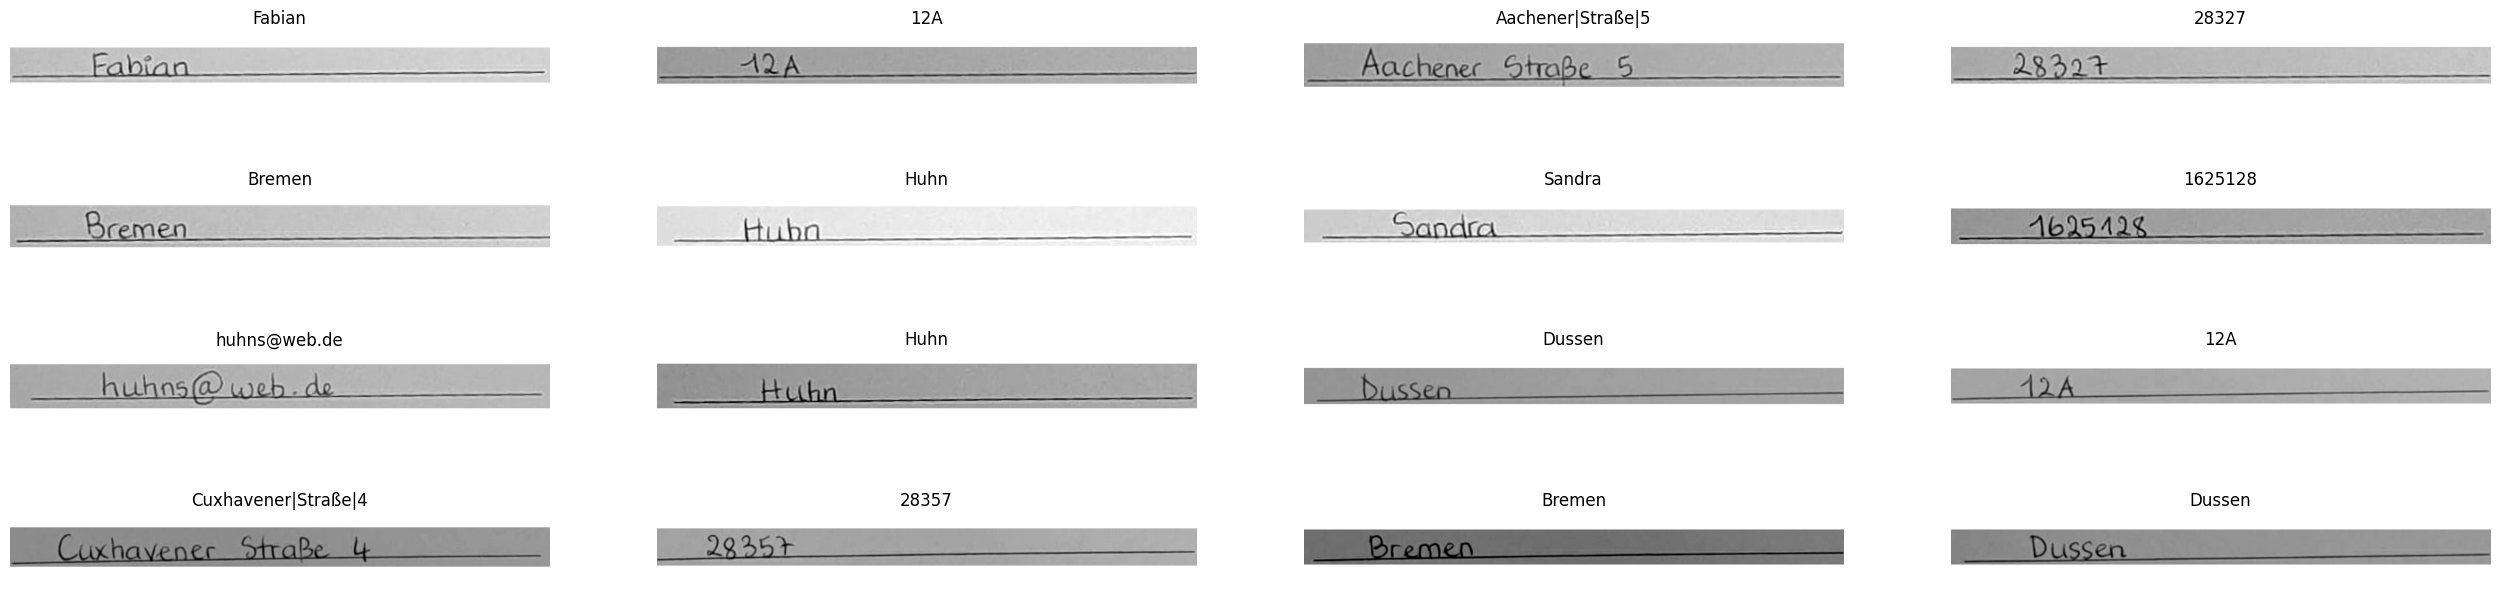

In [6]:
for data in aug_train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 8))[1]

    for i in range(min(16,BATCH_SIZE)):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()  

# Train Keras Model

In [7]:
weights_keras_string ="_weights.keras"

def model_load_weights_if_exists(model):
    """Loads model weights if they exist.

    This function checks if the model weights exist and loads them into the model.

    Args:
        model: The Keras model.

    Returns: 
        None
    """
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    print(model_path)
    if os.path.exists(model_path):
        print("Resuming Training where we left off!")
        model.load_weights(model_weight_path)

In [8]:
def train_model(model):
    """Trains the model and returns prediction model and training history.

    This function trains the provided model using the training and validation datasets.
    It also returns a prediction model and training history.

    Args:
        model: The Keras model to be trained.

    Returns:
        prediction_model: The model used for predictions.
        history: The training history.
    """
    #model_load_weights_if_exists(model)
        
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    early_stopping = EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE, min_lr=1e-9, verbose=2) 
    
    history = model.fit(aug_train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])  
    history.history["lr"] = model.optimizer.lr.numpy() 
    return prediction_model, history

In [9]:
from keras.callbacks import History

def combine_histories(history1, history2):
    # Initialize a new history object
    new_history = History()
    new_history.history = {}
    
    # Combine epoch data
    new_history.epoch = history1.epoch + [e + max(history1.epoch) + 1 for e in history2.epoch]
    
    # Ensure all keys from both histories are included
    all_keys = set(history1.history.keys()).union(set(history2.history.keys()))
    
    # Combine the histories
    for key in all_keys:
        # Handle cases where the key might not exist in one of the histories
        new_history.history[key] = history1.history.get(key, []) + history2.history.get(key, [])
    
    return new_history

# Transfer Model

In [10]:
def load_model_and_weights():
    """Loads a pre-trained model and its weights.

    This function, loads a pre-trained model and its weights
    from the specified directory. It checks if both the model and weights exist before loading.

    Returns:
        model: The pre-trained Keras model with loaded weights, if found. Default: model9v3_xl
    """
    weights_keras_string = "_weights.keras"
    MODEL_MODEL_PATH = MODEL_NAME
    MODEL_WEIGHT_PATH = MODEL_NAME + weights_keras_string
    model_path = os.path.join(MODEL_DIR_NAME, MODEL_MODEL_PATH)
    model_weight_path = os.path.join(model_path, MODEL_WEIGHT_PATH)
    
    model_weight_path = "models/keras/Model9v3_whitebq/Model9v3_whitebq_weights.keras"
    model_path = "models/keras/Model9v3_whitebq"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [11]:
model = load_model_and_weights()
max_len = len(tokenizer.char_to_num.get_vocabulary())
characters = tokenizer.char_to_num.get_vocabulary()
opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(optimizer=opt)
model.summary()

models/keras/Model9v3_whitebq
Loading pre-trained model and weights...
Model and weights loaded successfully.
Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 1024, 128,   0           []                               
                                1)]                                                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 1024, 128, 4  480         ['image[0][0]']                  
                                8)                                                                
                                                                                                  
 Conv2 (Conv2D)                 (None, 1024, 128, 9  41568       [

### Dense Layer Transfer

In [12]:
EPOCHS = 100
for layer in model.layers:
    if "dense2" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
start_time = time.time()
prediction_model, history1 = train_model(model)
total_duration = time.time() - start_time
print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

Epoch 1/100
19/19 [==============================] - 16s 452ms/step - loss: 43.0035 - val_loss: 31.0856
Epoch 2/100
19/19 [==============================] - 5s 285ms/step - loss: 29.3556 - val_loss: 28.6278
Epoch 3/100
19/19 [==============================] - 6s 292ms/step - loss: 27.1222 - val_loss: 26.7180
Epoch 4/100
19/19 [==============================] - 6s 290ms/step - loss: 26.1929 - val_loss: 26.3055
Epoch 5/100
19/19 [==============================] - 6s 304ms/step - loss: 25.6640 - val_loss: 25.7019
Epoch 6/100
19/19 [==============================] - 6s 307ms/step - loss: 25.1236 - val_loss: 25.4698
Epoch 7/100
19/19 [==============================] - 6s 304ms/step - loss: 24.8752 - val_loss: 25.4123
Epoch 8/100
19/19 [==============================] - 6s 304ms/step - loss: 24.3897 - val_loss: 24.3791
Epoch 9/100
19/19 [==============================] - 6s 307ms/step - loss: 23.6183 - val_loss: 24.7116
Epoch 10/100
19/19 [==============================] - 6s 306ms/step - lo

### Full Transfer

In [14]:
# EPOCHS = 100
# for layer in model.layers:
#     layer.trainable = True

In [15]:
# start_time = time.time()
# prediction_model, historyfull = train_model(model)
# total_duration = time.time() - start_time + total_duration
# print("Gesamte Trainingsdauer: {time}s".format(time=round(total_duration)))

In [16]:
#history1 = combine_histories(historydense, historyfull)

### Reduce Learning Rate

In [17]:
opt = keras.optimizers.Adam(LEARNING_RATE/10)
model.compile(optimizer=opt)
start_time = time.time()
prediction_model, history2 = train_model(model)
total_duration = time.time() - start_time + total_duration

Epoch 1/100
19/19 [==============================] - 6s 148ms/step - loss: 3.4702 - val_loss: 9.5583
Epoch 2/100
19/19 [==============================] - 2s 98ms/step - loss: 3.5725 - val_loss: 9.5045
Epoch 3/100
19/19 [==============================] - 2s 99ms/step - loss: 3.4442 - val_loss: 9.4653
Epoch 4/100
19/19 [==============================] - 2s 100ms/step - loss: 3.3627 - val_loss: 9.4339
Epoch 5/100
19/19 [==============================] - 2s 104ms/step - loss: 3.2909 - val_loss: 9.4221
Epoch 6/100
19/19 [==============================] - 2s 103ms/step - loss: 3.3037 - val_loss: 9.4072
Epoch 7/100
19/19 [==============================] - 2s 98ms/step - loss: 3.3726 - val_loss: 9.3928
Epoch 8/100
19/19 [==============================] - 2s 99ms/step - loss: 3.3062 - val_loss: 9.3739
Epoch 9/100
19/19 [==============================] - 2s 97ms/step - loss: 3.2356 - val_loss: 9.3701
Epoch 10/100
19/19 [==============================] - 2s 96ms/step - loss: 3.3150 - val_loss: 9.

In [18]:
history = combine_histories(history1, history2)

### Combine History


# Plot helper functions

In [19]:
def plot_history(history, name, dir_path, save_fig):
    """Plots the training history of a model.
    
    This function takes the training history of a model and plots the training and validation loss
    across epochs. It also plots the learning rate on a secondary y-axis using a logarithmic scale.

    Args:
        history: The training history of the model.
        name (str): The name of the model.
        dir_path (str): The directory path to save the plot.
        save_fig (bool): A flag indicating whether to save the plot as an image.

    Returns:
        None
    """
    metrics = history.history
    _, ax1 = plt.subplots()

    # Plot für Trainings- und Validierungsverluste
    ax1.plot(metrics['loss'], label='Training Loss', color='blue')
    ax1.plot(metrics['val_loss'], label='Validation Loss', color='red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95))  

    # Zweite Y-Achse für die Lernrate
    ax2 = ax1.twinx()
    #ax2.plot(metrics['lr'], label='Learning Rate', color='green')
    ax2.set_ylabel('Learning Rate', color='black')
    
    ax2.set_yscale('log')  # Verwende logarithmische Skala für die Lernrate
    
    ax2.tick_params('y', colors='black')
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:1.0e}'))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))  
    
    if save_fig:
        plt.title('Name: '+name)
        path = os.path.join(dir_path, name + '_history.png')
        plt.savefig(path)
        
    plt.show()

In [20]:
# Creates a directory if it doesn't exist
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [21]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_transfer_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [22]:
def plot_evaluation(name, dir_path, save_fig):
    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range((min(16,BATCH_SIZE))):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
    if save_fig:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)
        
    plt.show()

In [23]:
def create_new_plot_name(model_name, names, format):
    pattern = r"\d+"
    max_number = 0
    for name in names:
        tmp_name = name.replace(model_name,"")
        number = int(re.findall(pattern,tmp_name)[0])
        if number > max_number:
            max_number = number
            
    new_model_name = model_name + "V_" + str(max_number + 1)
    
    return format.replace(model_name,new_model_name)

# Model Testing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


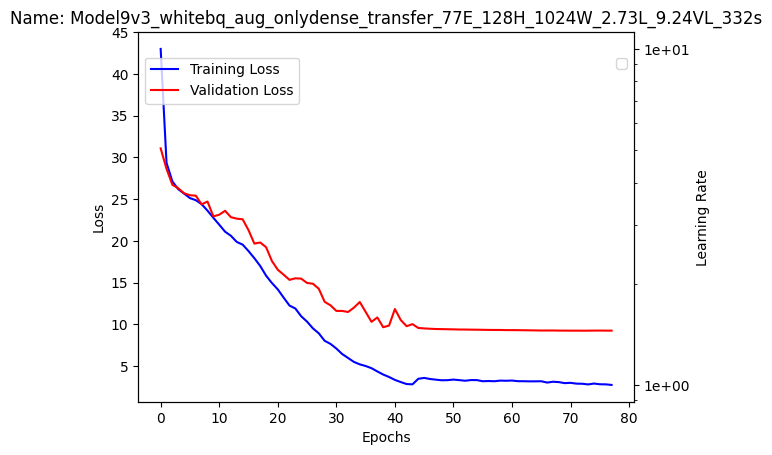

1/1 [==============================] - 1s 896ms/step


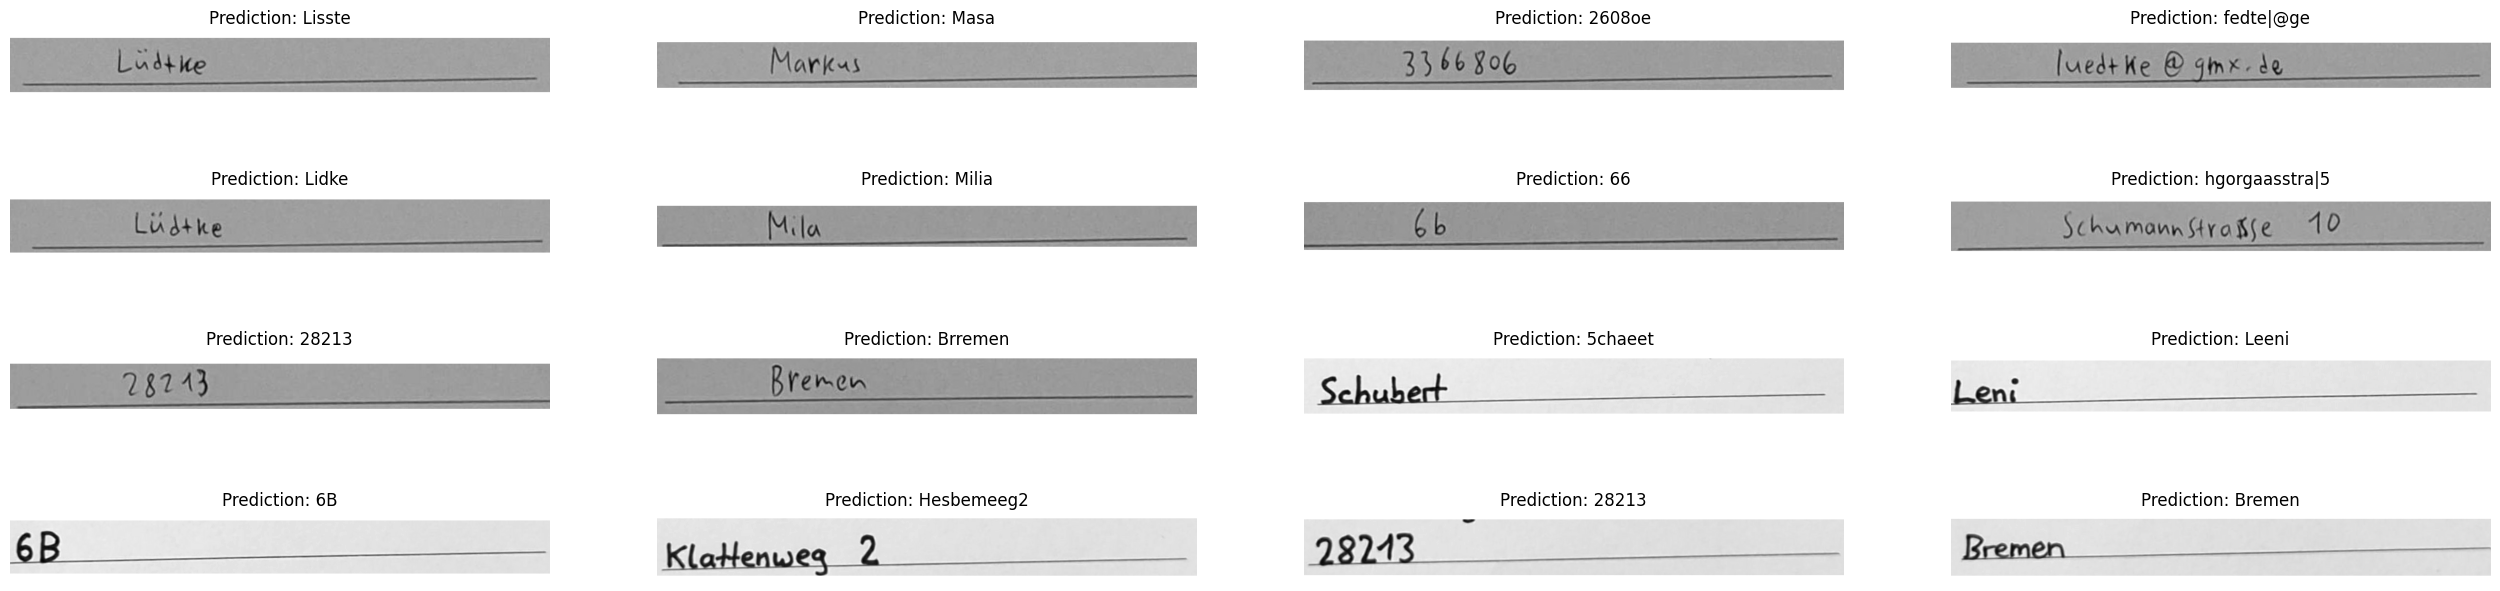

In [24]:
""" Creates a new plot name based on existing names.

This function generates a new plot name by appending a version number to the given model name.
The version number is determined based on existing plot names in the directory.

Args:
    model_name (str): The base model name.
    names (list): A list of existing plot names.
    format (str): The format string for the plot name.

Returns:
    str: The new plot name.
"""
if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL_{time}s".format(
    name=MODEL_NAME, epoch=history.epoch[-1], height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1],2), val_loss=round(metrics['val_loss'][-1], 2), time=round(total_duration))

if not files_with_model_name:
    if SAVE_HISTORY:
        plot_history(history, NAME, TEST_RESULT_DIR_NAME, True)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    new_name = create_new_plot_name(MODEL_NAME,files_with_model_name, NAME)
    plot_history(history, new_name, TEST_RESULT_DIR_NAME, True)
    plot_evaluation(new_name, TEST_RESULT_DIR_NAME, True)

# Save the Model

In [25]:
# Saves the model after training if MODEL_SAVE = True
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model_path = os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME))
    model.save(model_path)
    model.save_weights(os.path.join(model_path, f"{MODEL_NAME}{weights_keras_string}"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(model_path, f"{MODEL_NAME}.json"),'w') as f:
        f.write(json_string)

    data_to_save = (load_transfer_data.max_len, load_transfer_data.characters)
    import pickle
    with open(os.path.join(model_path, "handwriting_chars.pkl"), 'wb') as file:
        pickle.dump(data_to_save, file)

INFO:tensorflow:Assets written to: models/keras\Model9v3_whitebq_aug_onlydense_transfer\assets


INFO:tensorflow:Assets written to: models/keras\Model9v3_whitebq_aug_onlydense_transfer\assets
